<a href="https://colab.research.google.com/github/francasino/Ransomware_analysis/blob/main/hedge_office.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#load db and imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#change here the path to access data in your drive
path = "/content/drive/My Drive/Datasets/hedge_office/"

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from csv import reader
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
%load_ext google.colab.data_table

## choose path for DB. Original EXP or VS_RAW EXP

In [ ]:
datasets ={}
datasets[64]=pd.read_csv(path+"db_office_final/64_office.csv")
datasets[128]=pd.read_csv(path+"db_office_final/128_office.csv")
datasets[256]=pd.read_csv(path+"db_office_final/256_office.csv")
datasets[512]=pd.read_csv(path+"db_office_final/512_office.csv")
datasets[1024]=pd.read_csv(path+"db_office_final/1024_office.csv")

In [ ]:
datasets ={}
datasets[64]=pd.read_csv(path+"db_office_final_vs_raw/64_office.csv")
datasets[128]=pd.read_csv(path+"db_office_final_vs_raw/128_office.csv")
datasets[256]=pd.read_csv(path+"db_office_final_vs_raw/256_office.csv")
datasets[512]=pd.read_csv(path+"db_office_final_vs_raw/512_office.csv")
datasets[1024]=pd.read_csv(path+"db_office_final_vs_raw/1024_office.csv")

In [ ]:
datasets[1024].head(1)

,Filetype,Original,size,Entropy,Chi-score,Iterations,Monobit,Poker,Run,Long run,Frequency,Block Frequency,Cumulative Sums,Overlapping Template,jarque-bera,shapiro,squared_hist
0,0,6,1048576,7.994642,7783.295898,419,"[10045, 10108, 10041, 10542, 10422, 10573, 956...","[86.3104000000003, 350.71360000000004, 367.391...","[[2899, 1115, 563, 304, 150, 120], [3393, 1108...","[[0, 1], [0, 5], [0, 2], [0, 1], [0, 3], [2, 0...","[['0.000000'], ['*']]","[['0.000000'], ['*']]","[['0.000000', '0.000000'], ['*', '*']]","[['0.000439'], ['7/10']]",0.935977,0.992866,31880380.0


In [ ]:
# 0 fail, 1 pass
# fips 2

def check_monobit (x,g):
  for item in json.loads(x):
    if 9725-9725*g <= int(item) <= 10275+10275*g:
      pass
    else:
      return 0
  return 1

def check_poker (x,g):
  for item in json.loads(x):
    if 2.16-2.16*g <= float(item) <= 46.17+46.17*g:
      pass
    else:
      return 0
  return 1


def check_run (x,g):
  for sublist in json.loads(x):
    if 2343-2343*g <= int(sublist[0]) <= 2657+2657*g and 1135-1135*g <= int(sublist[1]) <= 1365+1365*g and 542-542*g <= int(sublist[2]) <= 708+708*g and 251-251*g <= int(sublist[3]) <= 373+373*g and 111-111*g <= int(sublist[4]) <= 201+201*g and 111-111*g <= int(sublist[5]) <= 201+201*g:
       pass
    else:
      return 0
  return 1

def check_long_runs(x,g):
  for sublist in json.loads(x):
    if int(sublist[0]) >= 26+26*g or int(sublist[1]) >= 26+26*g:
      return 0
  return 1



def check_chi(x,g):
  if x >= 255+(22*g):
      return 0
  return 1

In [ ]:
import statistics
import json
import joblib


##The following function transforms the complex outcomes of the tests into a single numerical variable and normalises the dataframe. It also removes some non-relevant features.
def createParsedDf_min (df,g,gh):
    dfr=df
    dfr['Monobit_'] = dfr['Monobit'].apply(lambda x : check_monobit(x,g) )
    dfr['Poker_'] = dfr['Poker'].apply(lambda x : check_poker(x,g))
    dfr['Run_n'] = dfr['Run'].apply(lambda x : check_run(x,g))
    dfr['Long_run_'] = dfr['Long run'].apply(lambda x : check_long_runs(x,g))
    dfr['Fips_out']= dfr['Monobit_'] & dfr['Poker_'] & dfr['Run_n'] & dfr['Long_run_']
    dfr['Fips_out']=  dfr['Fips_out'].astype(int)

    dfr['Block_freq'] = dfr['Block Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))
    dfr['Freq_average'] = dfr['Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))
    dfr['Cumu_sum'] = dfr['Cumulative Sums'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))
    dfr['Ov_temp'] = dfr['Overlapping Template'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))

    dfr.rename(columns={'jarque-bera': 'Jarque-Bera'}, inplace=True)
    dfr.rename(columns={'shapiro': 'Shapiro-Wilk'}, inplace=True)

    if gh!=0:
      dfr['Chi_score'] = dfr['Chi-score'].apply(lambda x : check_chi(x,gh))
    else:
      dfr['Chi_score'] = dfr['Chi-score']

    dfr = dfr.drop(['Monobit','Chi-score','Poker','squared_hist','Iterations','Run','Long run','Frequency','Block Frequency','Cumulative Sums','Overlapping Template'], axis=1)
    dfr = dfr.drop([' size'],axis=1)
    dfr.rename(columns={" Original": "Original"})
    cols_to_norm = ['Entropy',
 'Jarque-Bera',
 'Shapiro-Wilk',
 'Block_freq',
 'Freq_average',
 'Cumu_sum',
 'Ov_temp',
 'Chi_score']
    dfr[cols_to_norm] = dfr[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


    return dfr

In [ ]:
## TEST FOR ALL GAMMA VALUES. DEFAULT IS 0 for gammafips and 0 for gammahedge. gammahedge 0 is like gamma 1 in original hedge
## values for testing and playing
## gamma hedge like original, from 0.1 to e.g. 2 or more, intervals of 0.1
# gamma_fips_values = [0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2]
# gamma_hedge_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
gamma_fips_values = [0] ## after testing, higher values make pass more enc than comp so proportion is better. The higher the file, the more tolerance to have less strict values in fips, since comp will not pass them anyway.
## higher gamma fips than 0.1 does not yeld much better outcomes
gamma_hedge_values = [2] ##  there is a sweet spot between 2 and 3, but 3 is worse or shows no improvement.


datasets_test={} ## we this as backup for the different tests and not overwrite original

for val in datasets:
  for gammafips in gamma_fips_values:
    for gammahedge in gamma_hedge_values:
      datasets_test[val] = createParsedDf_min(datasets[val],gammafips,gammahedge)

In [ ]:
datasets[1024].head(1)

,Filetype,Original,size,Entropy,Chi-score,Iterations,Monobit,Poker,Run,Long run,...,Monobit_,Poker_,Run_n,Long_run_,Fips_out,Block_freq,Freq_average,Cumu_sum,Ov_temp,Chi_score
0,0,6,1048576,7.994642,7783.295898,419,"[10045, 10108, 10041, 10542, 10422, 10573, 956...","[86.3104000000003, 350.71360000000004, 367.391...","[[2899, 1115, 563, 304, 150, 120], [3393, 1108...","[[0, 1], [0, 5], [0, 2], [0, 1], [0, 3], [2, 0...",...,0,0,0,1,0,0.0,0.0,0.0,0.000439,0


###ML

In [ ]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
for dataset in datasets_test:
  datasets_test[dataset] = datasets_test[dataset].drop(['Fips_out', 'Run_n', 'Poker_', 'Long_run_'],axis=1)  ## we keep only monobit

In [ ]:
datasets_test[1024].columns

Index(['Filetype', ' Original', 'Entropy', 'Jarque-Bera', 'Shapiro-Wilk',
       'Monobit_', 'Block_freq', 'Freq_average', 'Cumu_sum', 'Ov_temp',
       'Chi_score'],
      dtype='object')

In [ ]:
import statistics

def calc_averages(dictio):  ##we can also do a boxplot but maybe not necessary, with the data is enough
  for key in dictio:
    dictio[key]= [statistics.mean(dictio[key]),statistics.stdev(dictio[key])]

In [ ]:
#For the best model or the selected one
from time import time


df= pd.DataFrame()
for dataset in datasets_test:
    y=datasets_test[dataset].Filetype
    X=datasets_test[dataset].drop(['Filetype',' Original'],axis=1)
    features = list(X.columns)
    model=RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=10,max_features=len(features),n_jobs=-1)
    print(len(features))
    model.feature_names = features
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) ##CHANGE TO 3
      # record the current time
    start = time()
      # evaluate the model
    n_scores = cross_validate(model, X, y, scoring=['precision','recall','accuracy','f1'], cv=cv,n_jobs=-1)# FIX this to 1 to see training performances
      # record the current time
    end = time()
      # store execution time
    result = end - start
    print("Dataset with size: "+str(dataset)+" and ORIGINAL file category OFFICE ")
    print(result)
    #print(n_scores)
    calc_averages(n_scores) ## average of all tests
    print(n_scores)
    df = pd.concat([df, pd.DataFrame.from_dict(n_scores)], ignore_index=True)
df.to_csv(path+'RF_multi_office.csv')

9
Dataset with size: 64 and ORIGINAL file category OFFICE 
8.922482967376709
{'fit_time': [0.5220890045166016, 0.16259674955447123], 'score_time': [0.06492106119791667, 0.019726330787638746], 'test_precision': [0.9818181818181818, 0.036985282015680576], 'test_recall': [0.99, 0.03051285766293646], 'test_accuracy': [0.985, 0.023304579984969973], 'test_f1': [0.9852130325814537, 0.023011286077469738]}
9
Dataset with size: 128 and ORIGINAL file category OFFICE 
6.195810794830322
{'fit_time': [0.35466252168019613, 0.019112559254873766], 'score_time': [0.04902259508768717, 0.003926807335920737], 'test_precision': [1.0, 0.0], 'test_recall': [1.0, 0.0], 'test_accuracy': [1.0, 0.0], 'test_f1': [1.0, 0.0]}
9
Dataset with size: 256 and ORIGINAL file category OFFICE 
9.195318222045898
{'fit_time': [0.5365373293558756, 0.16837583186379643], 'score_time': [0.06571698983510335, 0.017821339722947006], 'test_precision': [0.990909090909091, 0.027738961511760436], 'test_recall': [0.99, 0.03051285766293646

## boxplots entropy

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import entropy

def compute_entropy(file_path):
    with open(file_path, 'rb') as f:
        byte_arr = np.frombuffer(f.read(), dtype=np.uint8)
    byte_counts = np.bincount(byte_arr, minlength=256)
    probs = byte_counts / len(byte_arr)
    return entropy(probs, base=2)

def compute_monobit_test(file_path):
    chunk_size = 2500  # 20,000 bits / 8 bits per byte = 2,500 bytes
    with open(file_path, 'rb') as f:
        while True:
            chunk = f.read(chunk_size)
            if len(chunk) < chunk_size:
                break
            bit_arr = np.unpackbits(np.frombuffer(chunk, dtype=np.uint8))
            ones_count = np.sum(bit_arr)
            if not (9725 <= ones_count <= 10275):
                return False
    return True

def main(folder_path):
    subfolder_titles = ["txt", "mp3", "pdf", "office", "img", "video", "bin", "enc"]
    entropy_values = defaultdict(list)
    monobit_test_results = defaultdict(list)

    for subfolder in subfolder_titles:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if os.path.isfile(file_path):
                    try:
                        ent = compute_entropy(file_path)
                        monobit = compute_monobit_test(file_path)
                        entropy_values[subfolder].append(ent)
                        monobit_test_results[subfolder].append(monobit)
                    except Exception as e:
                        print(f"Could not process {file_path}: {e}")

    create_boxplots(entropy_values, monobit_test_results)
    create_boxplot(entropy_values)
    #create_boxplot_precise(entropy_values)

def main(folder_path):
    subfolder_titles = ["txt", "mp3", "pdf", "office", "img", "video", "bin", "comp", "enc"]
    entropy_values = defaultdict(list)
    monobit_test_results = defaultdict(list)

    for subfolder in subfolder_titles:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if os.path.isfile(file_path):
                    try:
                        ent = compute_entropy(file_path)
                        monobit = compute_monobit_test(file_path)
                        entropy_values[subfolder].append(ent)
                        monobit_test_results[subfolder].append(monobit)
                    except Exception as e:
                        print(f"Could not process {file_path}: {e}")
    create_boxplot(entropy_values)
    create_boxplots(entropy_values)
    create_boxplots_m(monobit_test_results)


def create_boxplots_m(monobit_test_results):
    labels = list(monobit_test_results.keys())

    monobit_data = [monobit_test_results[label] for label in labels if monobit_test_results[label]]

    # Filter labels to match the non-empty data lists
    filtered_labels = [label for label in labels if monobit_test_results[label]]

    fig, ax2 = plt.subplots(figsize=(12, 8))
    # Boxplot for Monobit Test Results
    monobit_data = [[1 if result else 0 for result in results] for results in monobit_data]  # Convert True/False to 1/0
    ax2.boxplot(monobit_data, labels=filtered_labels, showfliers=False)
    ax2.set_title('FIPS 140-2 Monobit Test Results')
    ax2.set_xlabel('File Types')
    ax2.set_ylabel('Monobit Test Outcome (1 = Pass, 0 = Fail)')
    ax2.set_ylim(-0.1, 1.1)  # Set y-axis limits to show the pass/fail clearly
    ax2.grid(True, linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def create_boxplots(entropy_values):
    labels = list(entropy_values.keys())
    entropy_data = [entropy_values[label] for label in labels if entropy_values[label]]

    # Filter labels to match the non-empty data lists
    filtered_labels = [label for label in labels if entropy_values[label]]

    fig, ax1 = plt.subplots(figsize=(12, 8))
    # Boxplot for Entropy
    ax1.boxplot(entropy_data, labels=filtered_labels, showfliers=False)
    ax1.set_title('Entropy of each file type')
    ax1.set_xlabel('File Types')
    ax1.set_ylabel('Entropy (bits)')
    ax1.set_ylim(7, 8)  # Set y-axis limits to focus on the range 7 to 8
    ax1.grid(True, linestyle='--', linewidth=0.5)



    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_boxplot(entropy_values):
    labels = list(entropy_values.keys())
    data = [entropy_values[label] for label in labels if entropy_values[label]]
    fig, ax = plt.subplots(figsize=(12, 8))
    # Filter labels to match the non-empty data lists
    filtered_labels = [label for label in labels if entropy_values[label]]


    ax.boxplot(data, labels=filtered_labels, showfliers=False)
    ax.set_title('Entropy of each file type')
    ax.set_xlabel('File Types')
    ax.set_ylabel('Entropy (bits)')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def create_boxplot_precise(entropy_values):
    labels = list(entropy_values.keys())
    data = [entropy_values[label] for label in labels if entropy_values[label]]

    # Filter labels to match the non-empty data lists
    filtered_labels = [label for label in labels if entropy_values[label]]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.boxplot(data, labels=filtered_labels, showfliers=False)
    ax.set_title('Entropy of each file type')
    ax.set_xlabel('File Types')
    ax.set_ylabel('Entropy (bits)')
    ax.set_ylim(7, 8)  # Set y-axis limits to focus on the range 7 to 8
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def create_boxplot_very_precise(entropy_values):
    labels = list(entropy_values.keys())
    data = [entropy_values[label] for label in labels if entropy_values[label]]

    # Filter labels to match the non-empty data lists
    filtered_labels = [label for label in labels if entropy_values[label]]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.boxplot(data, labels=filtered_labels, showfliers=False)
    ax.set_title('Entropy of each file type')
    ax.set_xlabel('File Types')
    ax.set_ylabel('Entropy (bits)')
    ax.set_ylim(7.9, 8)  # Set y-axis limits to focus on the range 7 to 8
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

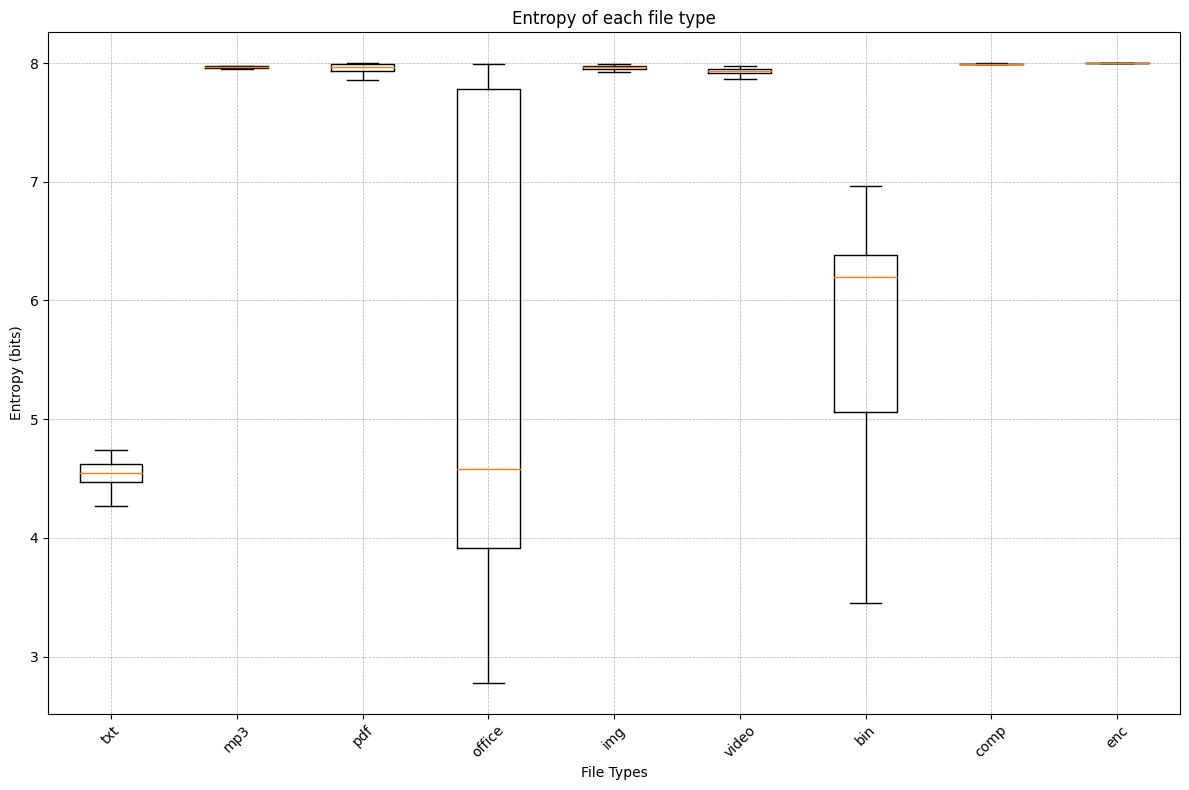

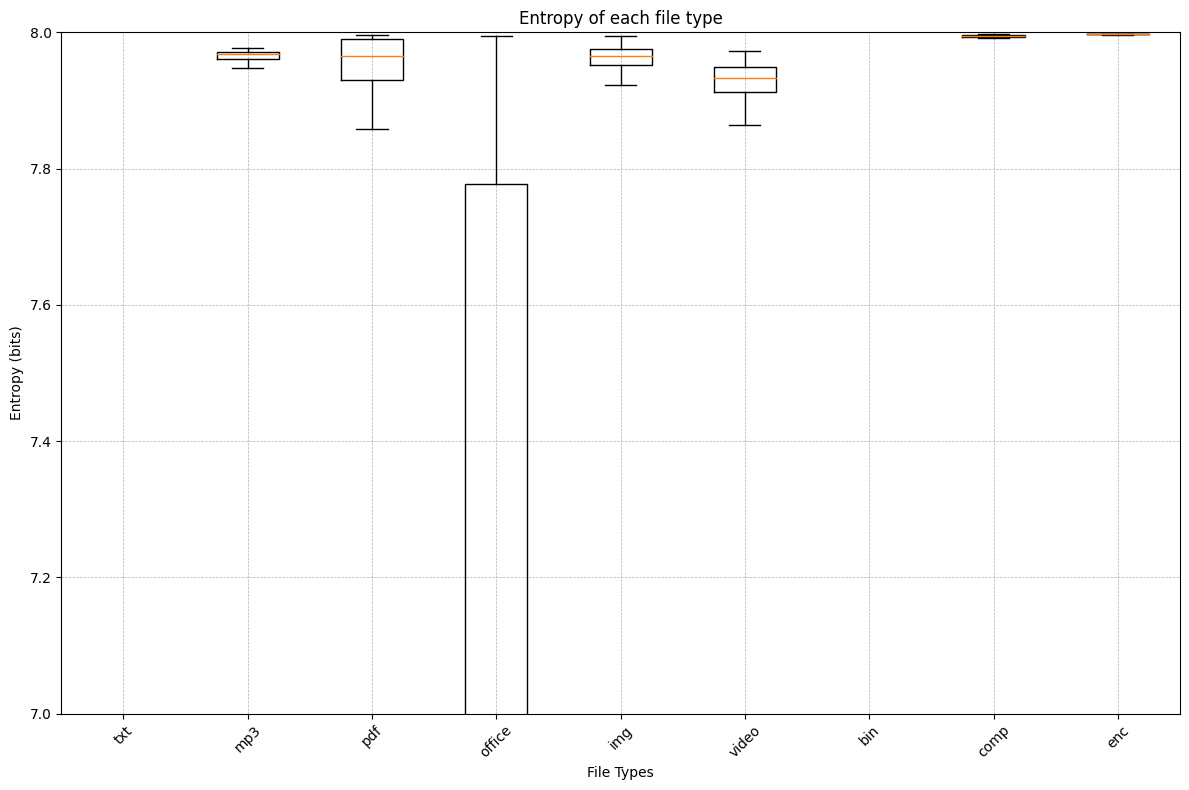

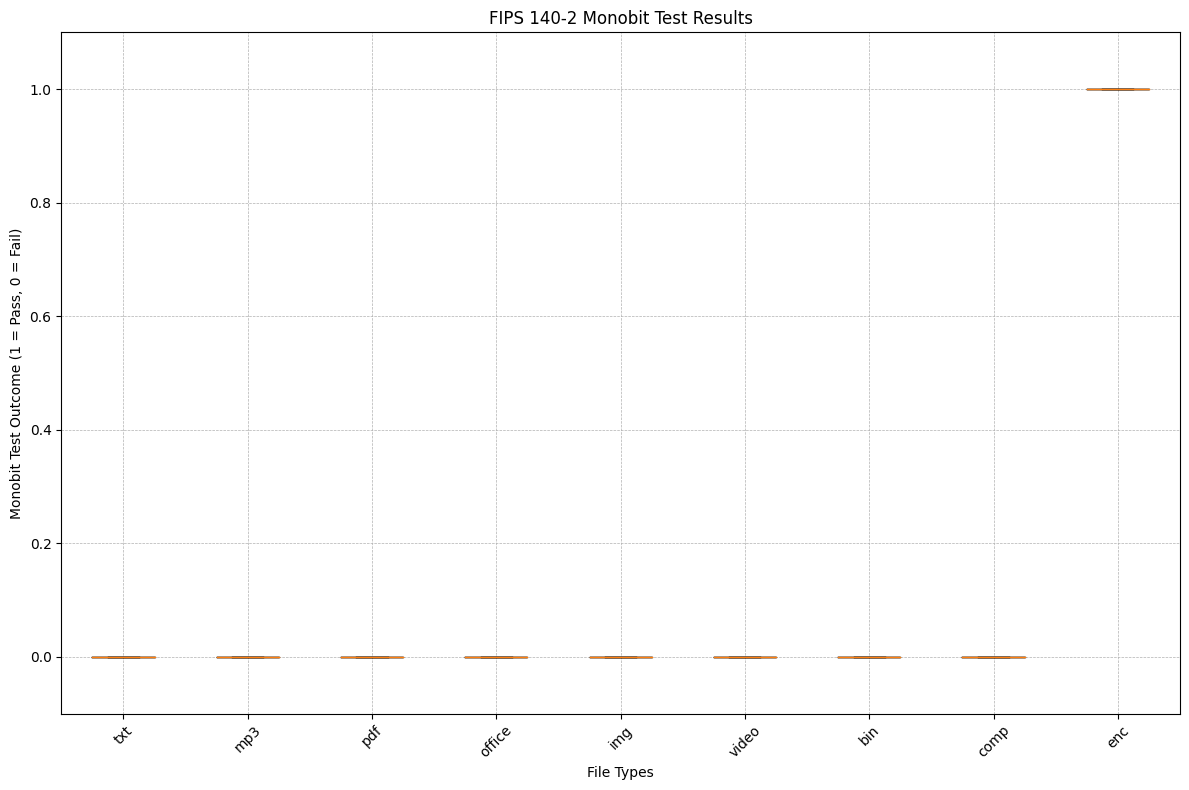

In [ ]:

if __name__ == "__main__":
    main("/content/drive/My Drive/Datasets/hedge_office/db_ori_raw_splits/")